# Add Folders to Path

In [2]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add PRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/PRA")

CPU times: user 209 µs, sys: 140 µs, total: 349 µs
Wall time: 260 µs


# Overview

In the following notebok we evaluate the Polar Rotation Angle (PRA) on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Polar Rotation Angle (PRA):

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary meshgrid. 
   
    * Compute left and right singular vectors $ \xi_{1,2}(\mathbf{x}_0), \eta_{1,2}(\mathbf{x}_0) $ of the gradient of the flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $.
    
    * Compute PRA as:
    
    \begin{equation}
    \mathrm{PRA}_{t_0}^{t_N}(\mathbf{x}_0) = \cos^{-1}(\langle \eta_{2}(\mathbf{x}_0), \xi_{2}(\mathbf{x}_0) \rangle) = \cos^{-1}(\langle \eta_{1}(\mathbf{x}_0), \xi_{1}(\mathbf{x}_0) \rangle).
    \end{equation}
    
    As the eigenvector associated to the maximum singular value of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ is numerically more stable we compute the PRA using $ \mathbf{\eta}_2, \mathbf{\xi}_2 $:
       
    \begin{equation}
    \mathrm{PRA}_{t_0}^{t_N}(\mathbf{x}_0) = \cos^{-1}(\langle \eta_{2}(\mathbf{x}_0), \xi_{2}(\mathbf{x}_0) \rangle).
    \end{equation}

# Import Data

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

CPU times: user 47.1 ms, sys: 23 ms, total: 70 ms
Wall time: 68.5 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [8]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 6

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [9]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size (in days)
dt = .1

time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = abs(tN-t0)

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# make sure that domain is in the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.025
dy = 0.025

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 1.16 ms, sys: 1.73 ms, total: 2.9 ms
Wall time: 1.87 ms


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [10]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 41 ms, sys: 3.64 ms, total: 44.6 ms
Wall time: 43 ms


# Polar Rotation Angle (PRA)

Next, we compute the PRA over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{5}, \dfrac{1}{10}] $. 

In [11]:
%%time
# Import gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for computing Polar Rotation Angle (PRA)
from ipynb.fs.defs.PRA import _PRA

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/10, 1/100]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 8), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 8)]

def parallel_PRA(i):
    
    PRA_parallel = X_domain[0,:].copy()*np.nan
    
    for j in range(X_domain.shape[1]):
        
        # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])
    
        # only compute PRA for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
    
            # compute gradient of flow map from finite differencing 
            gradFmap = gradient_flowmap(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
            # gradFmap has shape (2, 2, len(time)) --> we need gradient of flow map from t0 to tN
            gradFmap_t0_tN = gradFmap[:,:,-1]
        
            # compute PRA
            PRA_parallel[j] = _PRA(gradFmap_t0_tN)
            
        else:
            
            PRA_parallel[j] = np.nan
        
    return PRA_parallel

PRA = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_PRA)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/321 [00:00<?, ?it/s]

CPU times: user 6.12 s, sys: 2.52 s, total: 8.63 s
Wall time: 15min 34s


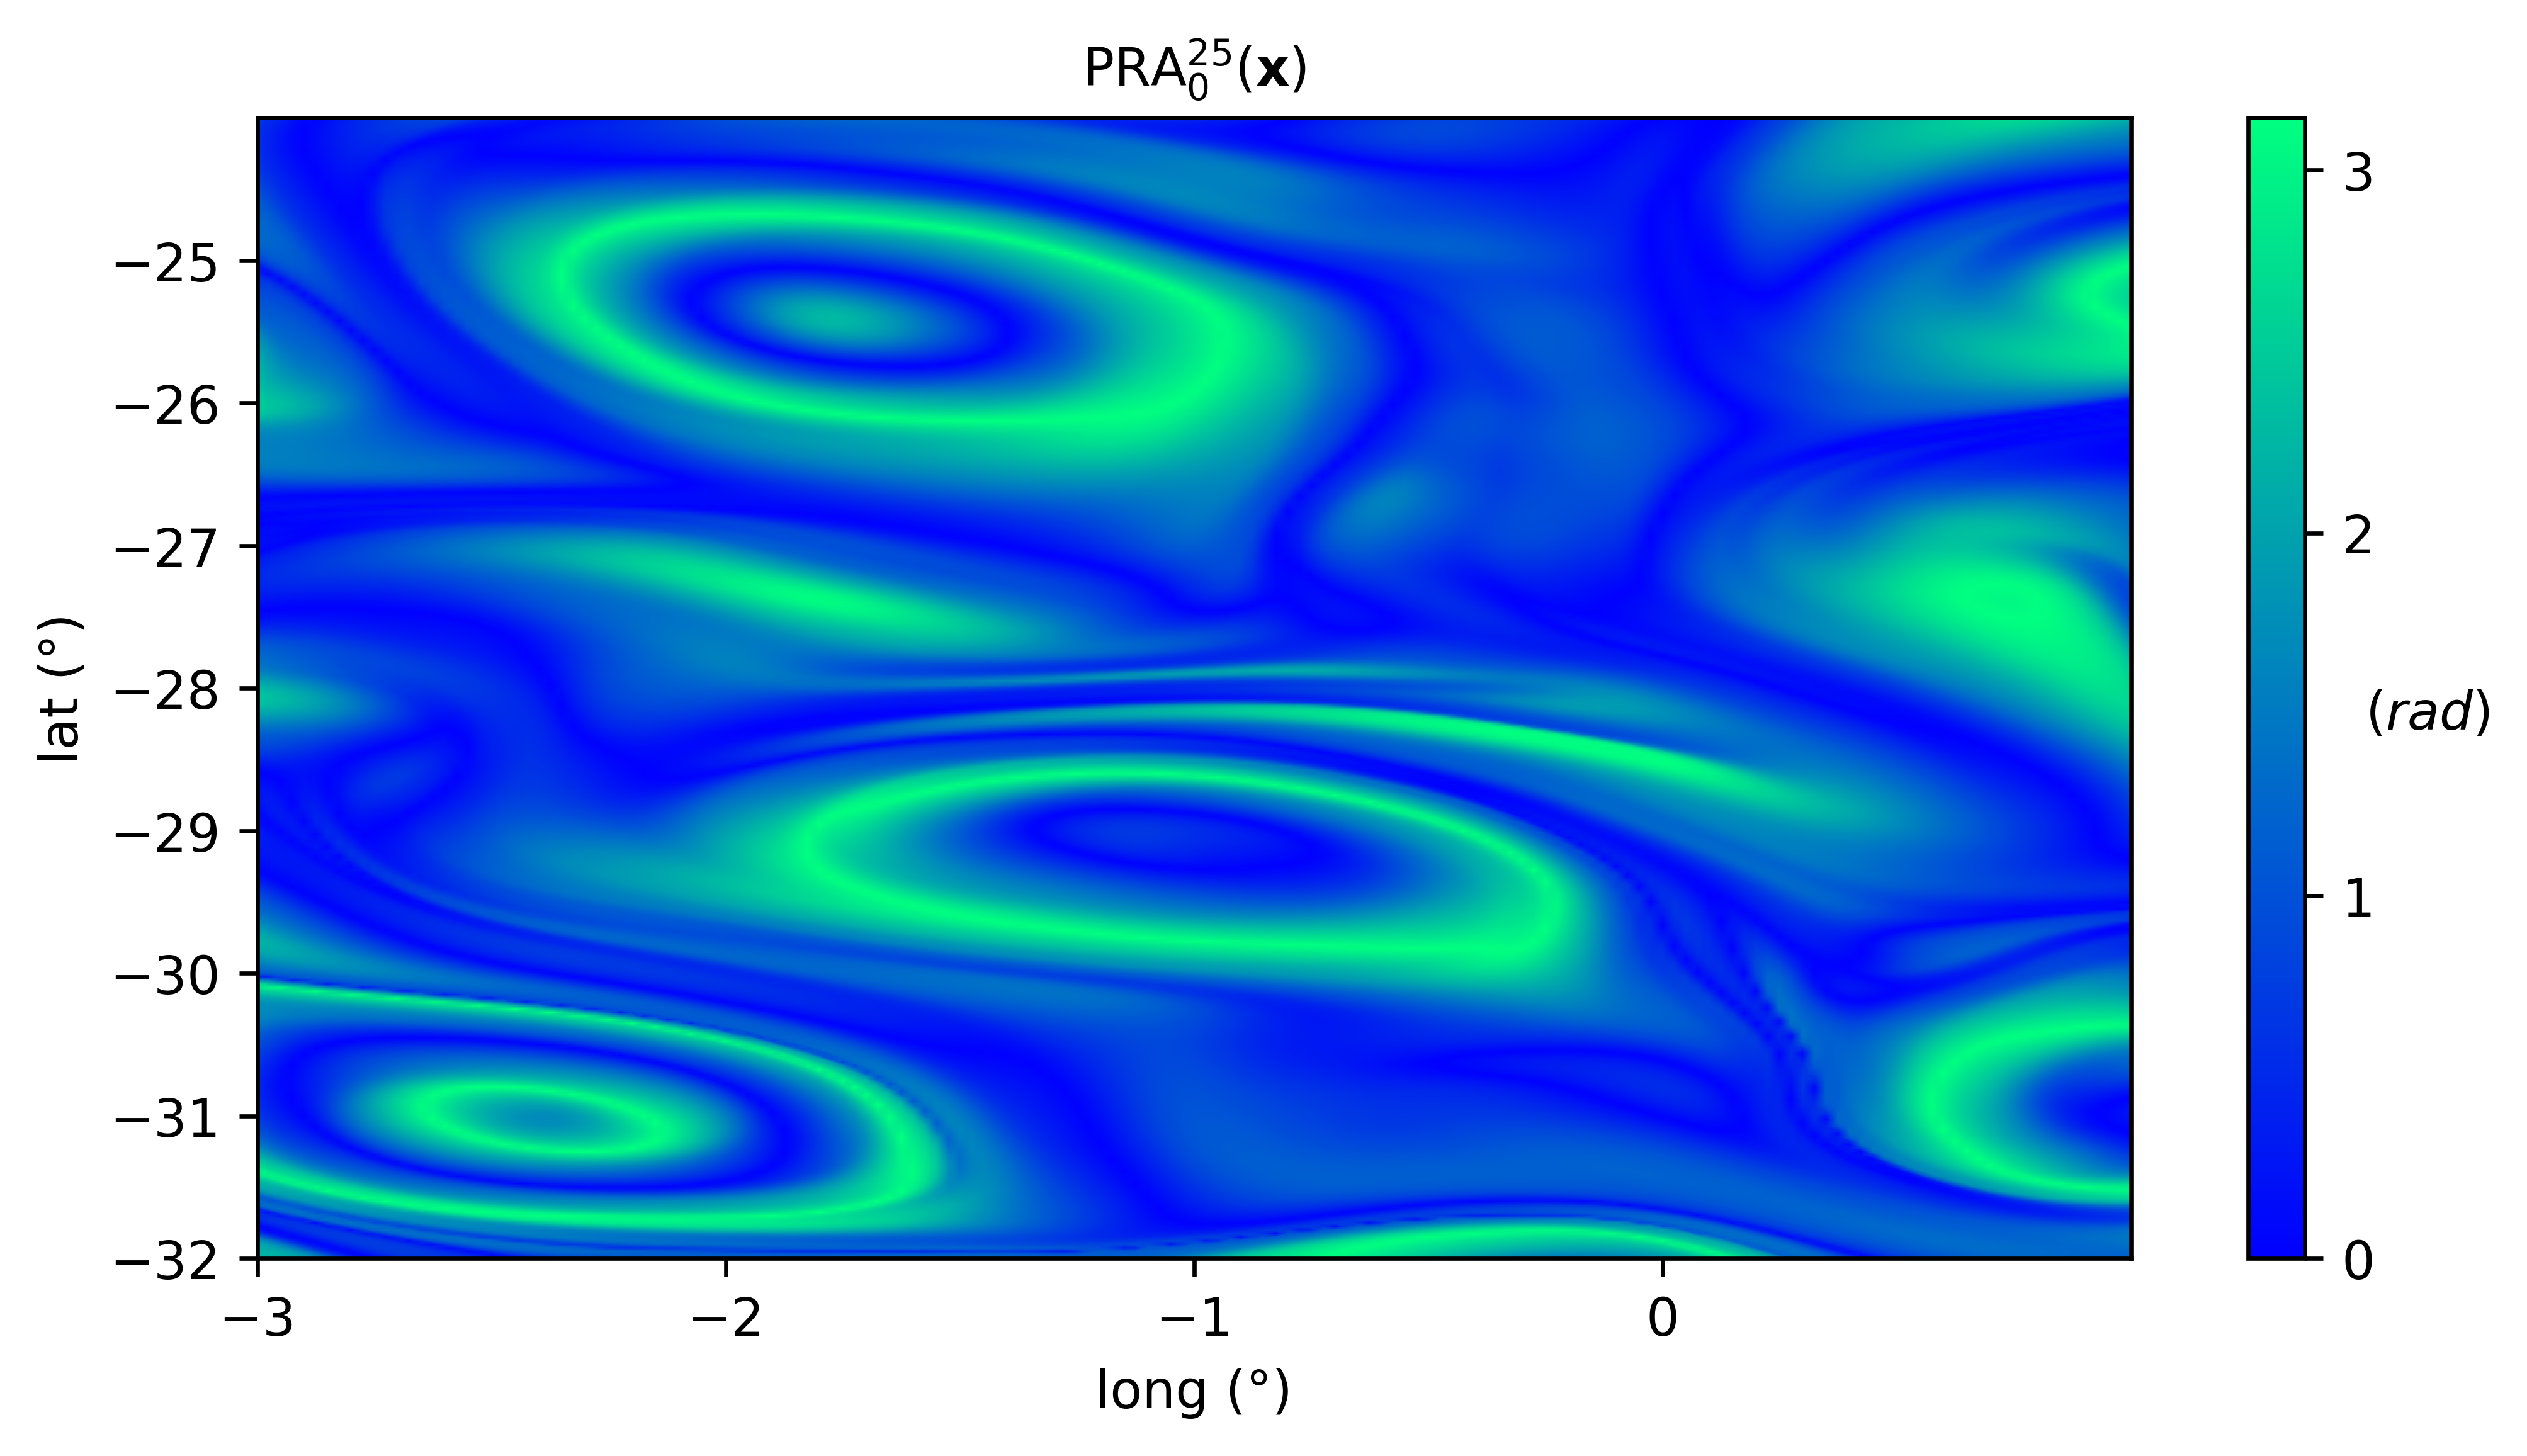

In [12]:
######################## PLOT RESULTS ########################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of PRA over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(PRA), cmap = "winter", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = [0, 1, 2, 3])
cbar.ax.set_ylabel(r'$(rad)$', rotation = 0, labelpad = 10, fontsize = 10)

# Title
ax.set_title(r'$ \mathrm{PRA}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$'+r'$(\mathbf{x})$', fontsize = 10)

plt.show()

Elliptic LCS are identified as elliptic islands around local extrema in the PRA field. The elliptic LCSs are visible as concentric closed contours of the PRA at time $ t_0 $. These elliptic islands clearly distinguish vortical regions from the remaining flow. Note that the $ \mathrm{PRA} $ highlights the same vortical flow structures as other commonly used rotation diagnostics such as the [Trajectory Rotation Average](../../TRA/Main/TRAAgulhas.ipynb), the [EllipticLCS](../../EllipticLCS/Main/EllipticLCSAgulhas.ipynb) or the [LAVD](../../LAVD/Main/LAVDAgulhas.ipynb).

# References

[1] Farazmand, M., & Haller, G. (2016). Polar rotation angle identifies elliptic islands in unsteady dynamical systems. Physica D: Nonlinear Phenomena, 315, 1-12.